In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [71]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader

In [128]:
ptbdb_normal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_normal.csv', header = None)
ptbdb_abnormal = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv', header = None)

In [129]:
ptbdb_normal.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
df = pd.concat([ptbdb_normal, ptbdb_abnormal])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (14552, 187)
y: (14552,)


In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 20, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle = True, random_state = 20, stratify = y_train)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().astype(int)
y_val = y_val.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)

X_train = torch.FloatTensor(X_train)
X_train = X_train.unsqueeze(dim=1)
X_val = torch.FloatTensor(X_val)
X_val = X_val.unsqueeze(dim=1)
X_test = torch.FloatTensor(X_test)
X_test = X_test.unsqueeze(dim=1)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [133]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.cv1d1 = nn.Conv1d(in_channels = 1, out_channels = 3, kernel_size = 32)
        self.cv1d2 = nn.Conv1d(in_channels = 3, out_channels = 10, kernel_size = 16)
        self.cv1d3 = nn.Conv1d(in_channels = 10, out_channels = 10, kernel_size = 8)
        self.mp = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(120, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 2)
    def forward(self, x):
        x = f.relu(self.cv1d1(x))
        x = self.mp(x)
        x = f.relu(self.cv1d2(x))
        x = self.mp(x)
        x = f.relu(self.cv1d3(x))
        x = self.mp(x)
        x = torch.flatten(x, start_dim = 1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        output = f.softmax(x)
        return output

In [134]:
model = Model()

In [135]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0008)

In [136]:
epochs = 500
train_losses = []
valid_losses = []
for i in range(1, epochs+1):
    y_pred = model.forward(X_train)
#     print(y_pred.shape)
#     print(y_train.shape)
    loss = criterion(y_pred, y_train)
    
    if i % 10 == 0:
        print(f'Train loss epoch {i}: {loss}')
        train_losses.append(loss.detach().numpy())
        model.eval()
        test_loss = 0
        with torch.no_grad():
            pred = model(X_val)
            valid_loss = criterion(pred, y_val)
        print(f'Validation loss poch {i}: {valid_loss}')
        valid_losses.append(valid_loss.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/tmp/ipykernel_34/1884562561.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = f.softmax(x)


Train loss epoch 10: 0.6503424048423767
Validation loss poch 10: 0.6502856612205505
Train loss epoch 20: 0.6365047693252563
Validation loss poch 20: 0.6363450288772583
Train loss epoch 30: 0.6084948182106018
Validation loss poch 30: 0.6079615354537964
Train loss epoch 40: 0.5871049761772156
Validation loss poch 40: 0.586575984954834
Train loss epoch 50: 0.5864468216896057
Validation loss poch 50: 0.586338222026825
Train loss epoch 60: 0.5843821167945862
Validation loss poch 60: 0.5843340158462524
Train loss epoch 70: 0.5808076858520508
Validation loss poch 70: 0.5806365013122559
Train loss epoch 80: 0.5770284533500671
Validation loss poch 80: 0.5767817497253418
Train loss epoch 90: 0.5717905163764954
Validation loss poch 90: 0.5716863870620728
Train loss epoch 100: 0.5638847351074219
Validation loss poch 100: 0.5642005801200867
Train loss epoch 110: 0.5572100281715393
Validation loss poch 110: 0.5586854815483093
Train loss epoch 120: 0.5509225726127625
Validation loss poch 120: 0.55259

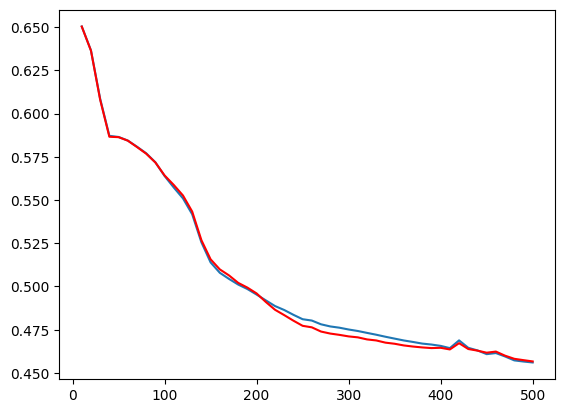

In [137]:
plt.plot(np.arange(10, 501, 10), train_losses)
plt.plot(np.arange(10, 501, 10), valid_losses, c = 'red')

In [139]:
from sklearn.metrics import accuracy_score
output_pred = model(X_test)
y_pred = torch.argmax(output_pred, dim = 1)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8413461538461539


/tmp/ipykernel_34/1884562561.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = f.softmax(x)
